In [136]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [137]:
env = gym.make('Taxi-v2')

In [138]:
print(env.nS, env.nA)

500 6


In [139]:
np.zeros((env.nS, env.nA))

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [140]:
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
    return counter

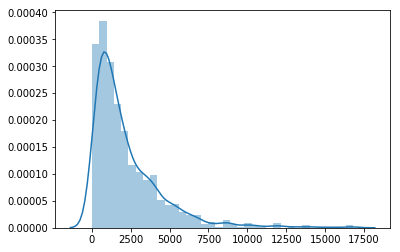

In [141]:
counts = [random_policy_steps_count() for _ in range(1000)]
sns.distplot(counts)

In [142]:
np.mean(counts)

2243.072

In [143]:
def value_iteration(env, epsilon=0.0001, gamma=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.env.P[state][a]:
                A[a] += prob * (reward + gamma * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    iterations = 0
    
    while True:
        
        iterations += 1
        delta = 0  #checker for improvements across states
        for state in range(env.nS):
            act_values = one_step_lookahead(state,V)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            delta = max(delta, np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < epsilon:  #if max improvement less than threshold
            break
            
    policy = np.zeros([env.nS, env.nA])
    for state in range(env.nS):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state, V)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1
        
    print('Iterations took:', iterations)
    return policy, V, iterations

In [144]:
def pol_eval(policy, env, gamma=1.0, epsilon=0.00001):
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    
    while True:

        delta = 0  #delta = change in value of state from one iteration to next
       
        for state in range(env.nS):  #for all states
            val = 0  #initiate value as 0
            
            #for all actions/action probabilities
            for action, act_prob in enumerate(policy[state]):
                #transition probabilities,state,rewards of each action
                for prob, next_state, reward, done in env.env.P[state][action]:
                    val += act_prob * prob * (reward + gamma * V[next_state])  #eqn to calculate
                    
            delta = max(delta, np.abs(val-V[state]))
            V[state] = val
        if delta < epsilon:  #break if the change in value is less than the threshold (theta)
            break
    return np.array(V)

In [145]:
def policy_iteration(env, policy_eval_fn=pol_eval, gamma=1.0):
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.env.P[state][a]:
                A[a] += prob * (reward + gamma * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.zeros([env.nS, env.nA])
    iterations = 0
    
    while True:
        
        iterations += 1
        curr_pol_val = policy_eval_fn(policy, env, gamma)  #eval current policy
        policy_stable = True  #Check if policy did improve (Set it as True first)
        for state in range(env.nS):  #for each states
            chosen_act = np.argmax(policy[state])  #best action (Highest prob) under current policy
            act_values = one_step_lookahead(state,curr_pol_val)  #use one step lookahead to find action values
            best_act = np.argmax(act_values) #find best action
            if chosen_act != best_act:
                policy_stable = False  #Greedily find best action
            policy[state] = np.eye(env.nA)[best_act]  #update 
        if policy_stable:
            print('Iterations took:', iterations)
            return policy, curr_pol_val, iterations
    
    print('Iterations took:', iterations)
    return policy, np.zeros(env.nS), iterations

In [183]:
def count(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[curr_state]))  
        curr_state = state
        counter += 1
    return counter

### Value iteration

In [184]:
env = gym.make('Taxi-v2')

val_p = []
times = []
gammas = np.arange(0.3, 1, 0.05)
for g in gammas:
    start = time.time()
    val_p.append(value_iteration(env, gamma=g))
    end = time.time()
    times.append(end - start)
    env.reset()

Iterations took: 11
Iterations took: 11
Iterations took: 12
Iterations took: 13
Iterations took: 14
Iterations took: 16
Iterations took: 17
Iterations took: 20
Iterations took: 23
Iterations took: 27
Iterations took: 33
Iterations took: 43
Iterations took: 63
Iterations took: 124


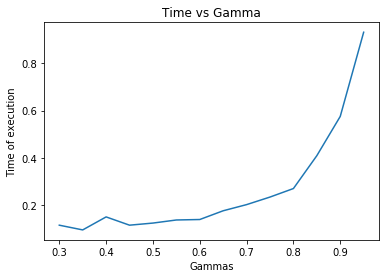

In [185]:
plt.title('Time vs Gamma')
plt.xlabel('Gammas')
plt.ylabel('Time of execution')
plt.plot(gammas, times)

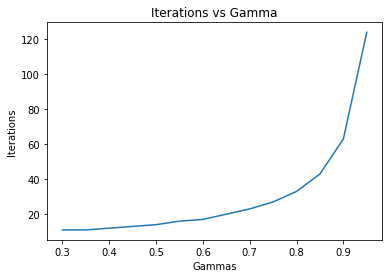

In [186]:
iters = [x[2] for x in val_p]
plt.title('Iterations vs Gamma')
plt.xlabel('Gammas')
plt.ylabel('Iterations')
plt.plot(gammas, iters)

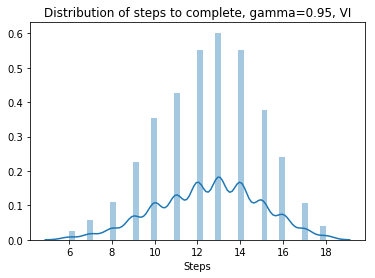

In [258]:
val_iter_policy = val_p[-1][0]
val_counts = [count(val_iter_policy) for i in range(10000)]
plt.title('Distribution of steps to complete, gamma=0.95, VI')
plt.xlabel('Steps')
sns.distplot(val_counts)

### Policy iteration

In [188]:
env = gym.make('Taxi-v2')

pol_p = []
times = []
gammas = np.arange(0.3, 1, 0.05)
for g in gammas:
    start = time.time()
    p = policy_iteration(env, pol_eval, gamma=g)
    pol_p.append(p)
    end = time.time()
    times.append(end - start)
    env.reset()

Iterations took: 16
Iterations took: 16
Iterations took: 17
Iterations took: 17
Iterations took: 17
Iterations took: 17
Iterations took: 17
Iterations took: 17
Iterations took: 17
Iterations took: 17
Iterations took: 17
Iterations took: 17
Iterations took: 17
Iterations took: 17


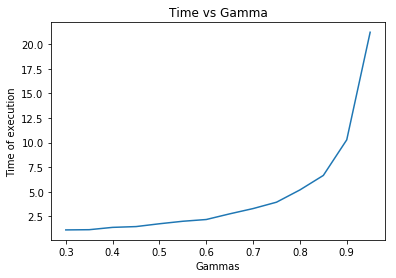

In [189]:
plt.title('Time vs Gamma')
plt.xlabel('Gammas')
plt.ylabel('Time of execution')
plt.plot(gammas, times)

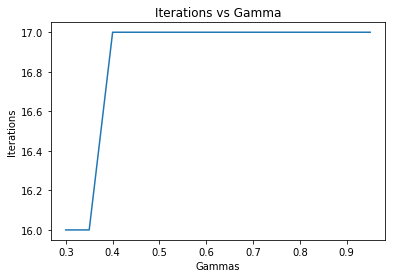

In [190]:
iters = [x[2] for x in pol_p]
plt.title('Iterations vs Gamma')
plt.xlabel('Gammas')
plt.ylabel('Iterations')
plt.plot(gammas, iters)

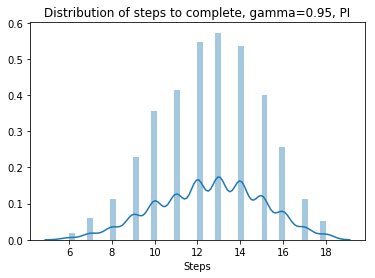

In [259]:
pol_iter_policy = pol_p[-1][0]
pol_counts = [count(pol_iter_policy) for i in range(10000)]
plt.title('Distribution of steps to complete, gamma=0.95, PI')
plt.xlabel('Steps')
sns.distplot(pol_counts)

In [260]:
print(np.mean(val_counts), np.mean(pol_counts))

12.5125 12.5635


In [193]:
# Gamma = 0.95

for x in range(len(pol_iter_policy)):
    if not (pol_iter_policy[x] == val_iter_policy[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

Same Policy


### Q Learning

In [206]:
def q_learn(epsilon=0.1, episodes=3000, alpha=0.8, gamma=0.95):
    
    env = gym.make('Taxi-v2')
    env = env.unwrapped
    
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    start=time.time()
    iterations = []
    
    # Start
    for episode in range(episodes):
        state = env.reset()
        done = False
        r = 0
        iteration = 0
        
        while not done:

            current = state
            
            # epsilon-greedy approach
            
            rand = np.random.uniform()
            if rand < epsilon:
                # the sample() method from the environment allows
                # to randomly sample an action from the set of actions
                action = env.action_space.sample()
            else:
                # act greedily by selecting the best action possible in the current state
                action = np.argmax(Q[current, :])

            state, reward, done, info = env.step(action)  
            r += reward
            iteration += 1
            Q[current, action] += alpha * (reward + gamma * np.max(Q[state, :]) - Q[current, action])

        rewards.append(r)
        iterations.append(iteration)
        
    env.close()
    end = time.time()
    print("time :",end-start)
    return Q, rewards, iterations, end-start

In [207]:
alpha = [0.4, 0.6, 0.8]
gamma = [0.35, 0.65, 0.95]
results = []

for a in alpha:
    for g in gamma:
        print('alpha =', a, 'gamma =', g)
        result = q_learn(epsilon=0.1, episodes=3000, alpha=a, gamma=g)
        results.append(result)

alpha = 0.4 gamma = 0.35
time : 1.3245203495025635
alpha = 0.4 gamma = 0.65
time : 1.0999267101287842
alpha = 0.4 gamma = 0.95
time : 1.0548462867736816
alpha = 0.6 gamma = 0.35
time : 1.0969195365905762
alpha = 0.6 gamma = 0.65
time : 0.9916377067565918
alpha = 0.6 gamma = 0.95
time : 0.9408583641052246
alpha = 0.8 gamma = 0.35
time : 0.9806077480316162
alpha = 0.8 gamma = 0.65
time : 0.9645628929138184
alpha = 0.8 gamma = 0.95
time : 0.9344861507415771


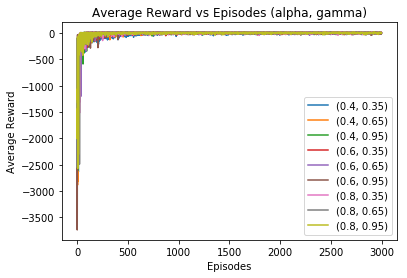

In [208]:
episodes = 3000
tmp = [(x,y) for x in alpha for y in gamma]

# plt.figure(figsize=(16, 8))
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes (alpha, gamma)')

for i, result in enumerate(results):

    plt.plot(range(episodes), result[1], label=tmp[i])

plt.legend()

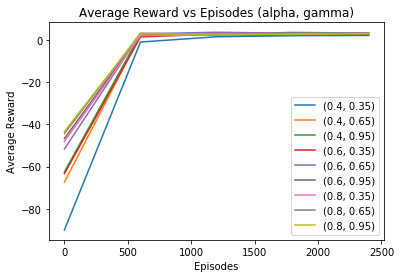

In [216]:
# Plot results
def chunk_list(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

episodes = 3000
size = int(episodes / 5)
avg = []
tmp = [(x,y) for x in alpha for y in gamma]

plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes (alpha, gamma)')

for i, result in enumerate(results):
    r = result[1]
    chunks = list(chunk_list(r, size))
    averages = [sum(chunk) / len(chunk) for chunk in chunks]

    plt.plot(range(0, len(r), size), averages, label=tmp[i])

plt.legend()

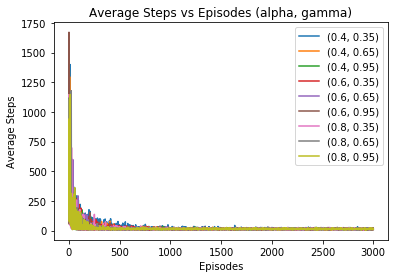

In [209]:
plt.xlabel('Episodes')
plt.ylabel('Average Steps')
plt.title('Average Steps vs Episodes (alpha, gamma)')

for i, result in enumerate(results):

    plt.plot(range(episodes), result[2], label=tmp[i])

plt.legend()

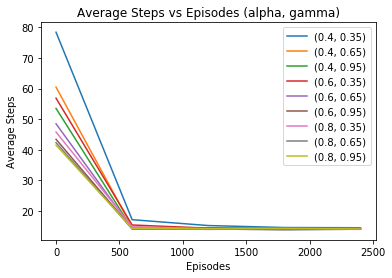

In [217]:
# Plot results
def chunk_list(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

episodes = 3000
size = int(episodes / 5)
avg = []
tmp = [(x,y) for x in alpha for y in gamma]

plt.xlabel('Episodes')
plt.ylabel('Average Steps')
plt.title('Average Steps vs Episodes (alpha, gamma)')

for i, result in enumerate(results):
    r = result[2]
    chunks = list(chunk_list(r, size))
    averages = [sum(chunk) / len(chunk) for chunk in chunks]

    plt.plot(range(0, len(r), size), averages, label=tmp[i])

plt.legend()

<BarContainer object of 9 artists>

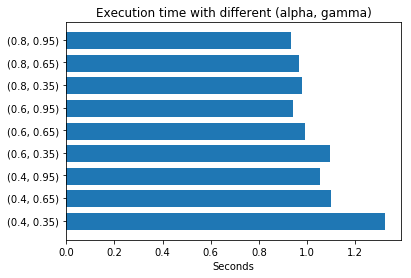

In [218]:
times = [r[3] for r in results]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(times))  # the x locations for the groups

ax.set_yticks(ind+width/20)
ax.set_yticklabels(tmp, minor=False)
plt.title('Execution time with different (alpha, gamma)')
plt.xlabel('Seconds')
ax.barh(ind, times, width)

In [219]:
Q, rewards, iterations, time_diff = q_learn(alpha=0.8, gamma=0.95)

time : 0.9465174674987793


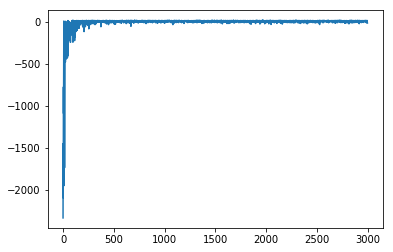

In [224]:
plt.plot(rewards)

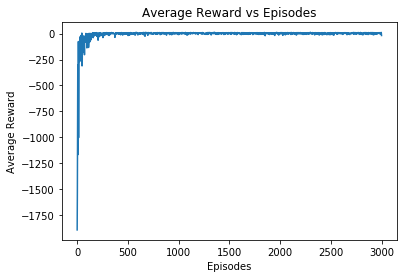

In [228]:
# Plot results
def chunk_list(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

episodes = 3000
size = int(episodes / 1500)

plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')


chunks = list(chunk_list(rewards, size))
averages = [sum(chunk) / len(chunk) for chunk in chunks]

plt.plot(range(0, len(rewards), size), averages)

In [229]:
# Start with a random policy
q_policy = np.zeros([env.nS, env.nA])

for state in range(env.nS):  #for each states
    best_act = np.argmax(Q[state]) #find best action
    q_policy[state] = np.eye(env.nA)[best_act]

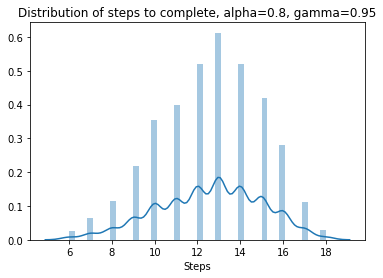

In [232]:
Q_counts = [count(q_policy) for i in range(10000)]
plt.title('Distribution of steps to complete, alpha=0.8, gamma=0.95')
plt.xlabel('Steps')
sns.distplot(Q_counts)

In [233]:
np.mean(Q_counts)

12.5637

In [245]:
for x in range(500):
    if not (q_policy[x] == val_iter_policy[x]).all():
        print("Not the same Policy")
#         break
    else:
        print("Same Policy")

Not the same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Not the same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Not the same Policy
Same Policy
Same Policy
Not the same Policy
Same Policy
Same Policy
Not the same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Not the same Policy
Not the same Policy
Same Policy
Not the same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Not the same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Not the same Policy
Not the same Policy
Not the same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
Not the same Policy
Not the same Policy
Same Policy
Same Policy
Not the same Policy
Same Policy
Same Policy
Same Policy
Not the same Policy
Same Policy
Same Policy
Same Pol

In [250]:
def view_policy(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[curr_state])) 
        curr_state = state
        counter += 1
        env.env.s = curr_state
        env.render()
    print('Total steps:', counter)

In [255]:
view_policy(pol_iter_policy)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y

In [256]:
view_policy(val_iter_policy)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|_: : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Total steps: 7


In [257]:
view_policy(q_policy)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | :_:G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Total steps: 9
